# III. Ứng dụng biến đổi ảnh cơ bản trong thực tế:

## 1. Tiền xử lý ảnh cho nhận diện biển số xe.

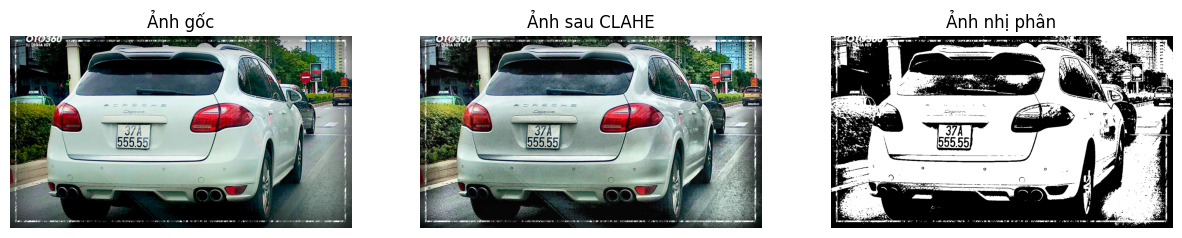

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def Tien_Xu_Ly_Bien_So(image_path, clip_limit=3.0, tile_grid_size=(8,8), thresh_type="otsu"):

    # Đọc ảnh
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Không tìm thấy ảnh: {image_path}")

    # B1: CLAHE trên kênh L của LAB 
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)   # Tách thành 3 kênh: L (sáng), A, B
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    l_clahe = clahe.apply(l)
    lab_clahe = cv2.merge((l_clahe, a, b))
    img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

    # B2: Chuyển sang ảnh xám 
    gray = cv2.cvtColor(img_clahe, cv2.COLOR_BGR2GRAY)

    # B3: Nhị phân hóa 
    if thresh_type == "global":
        # Ngưỡng cố định (dùng ngưỡng 127)
        _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    elif thresh_type == "otsu":
        # Otsu's thresholding
        _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    elif thresh_type == "adaptive":
        # Adaptive threshold
        binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY, 11, 2)
    else:
        raise ValueError("thresh_type phải là: 'global', 'otsu', hoặc 'adaptive'")

    return img, img_clahe, binary


def show_results(img, img_clahe, binary):
    plt.figure(figsize=(15,5))

    plt.subplot(1,3,1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Ảnh gốc")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(cv2.cvtColor(img_clahe, cv2.COLOR_BGR2RGB))
    plt.title("Ảnh sau CLAHE")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(binary, cmap="gray")
    plt.title("Ảnh nhị phân")
    plt.axis("off")

    plt.show()


# Test
iname = "img/Bien_So_Xe.jpg"
img, img_clahe, binary = Tien_Xu_Ly_Bien_So(iname, thresh_type="otsu")
show_results(img, img_clahe, binary)


## 2. Xử lý ảnh chụp từ vệ tinh

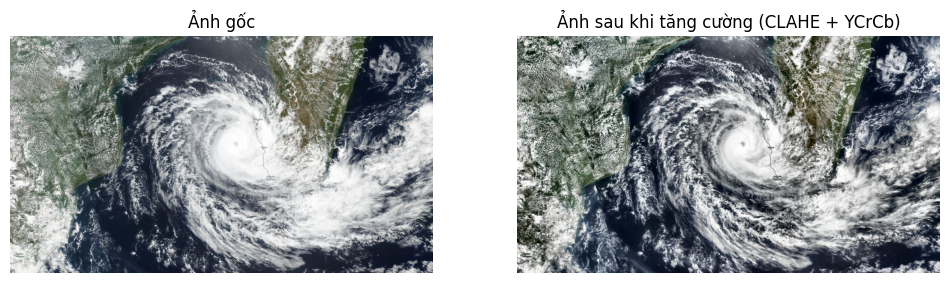

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt   

def Anh_GIS(image_path, clip_limit=3.0, tile_grid_size=(8,8)):
    # 1. Đọc ảnh
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Không tìm thấy ảnh: {image_path}")
    
    # 2. Chuyển sang không gian YCrCb
    ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    Y, Cr, Cb = cv2.split(ycrcb)
    
    # 3. Áp dụng CLAHE trên kênh Y
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    Y_eq = clahe.apply(Y)
    
    # 4. Ghép lại
    ycrcb_eq = cv2.merge([Y_eq, Cr, Cb])
    img_enhanced = cv2.cvtColor(ycrcb_eq, cv2.COLOR_YCrCb2BGR)
    
    
    # Hiển thị ảnh
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    enhanced_rgb = cv2.cvtColor(img_enhanced, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(img_rgb)
    plt.title("Ảnh gốc")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(enhanced_rgb)
    plt.title("Ảnh sau khi tăng cường (CLAHE + YCrCb)")
    plt.axis("off")

    plt.show()
    
    return img_enhanced

# Test
result = Anh_GIS("img/Anh_Ve_Tinh.png", clip_limit=3.0, tile_grid_size=(8,8))


## 3. Ảnh chụp trong điều kiện thiếu ánh sáng

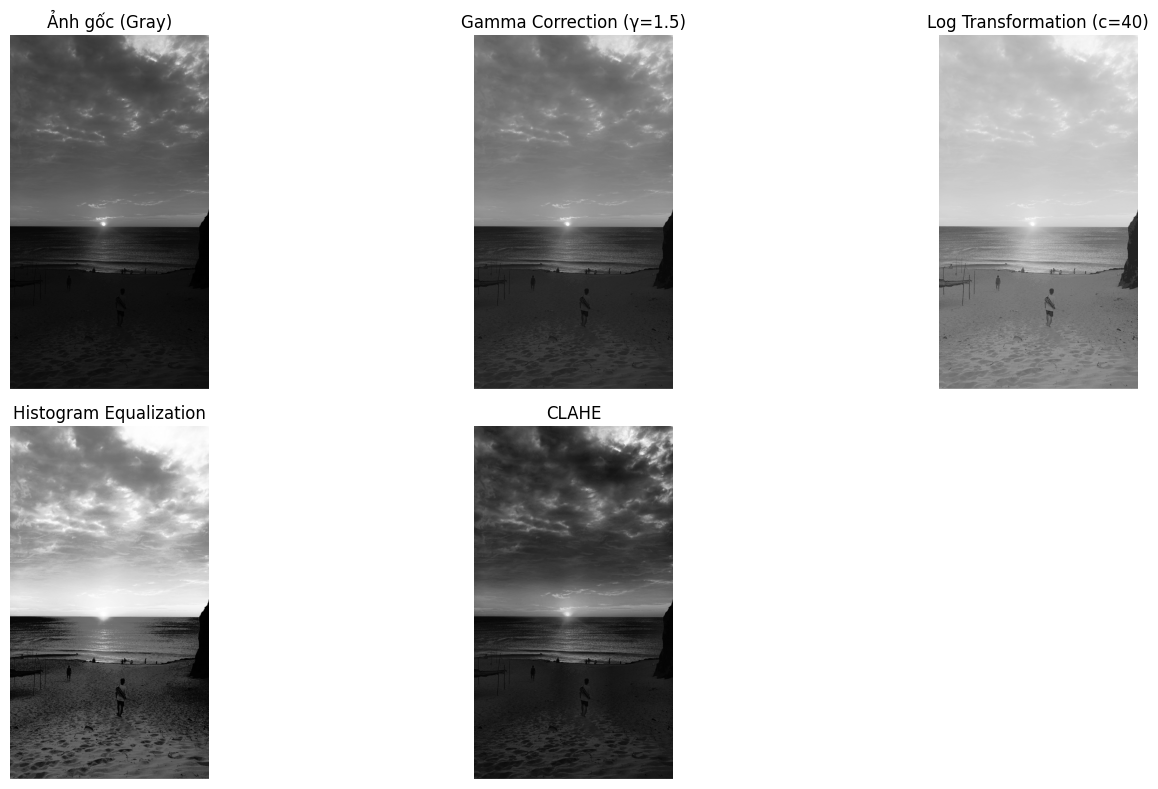

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def XuLy_Anh_ThieuSang(image_path, gamma=1.5, c_log=30, clip_limit=3.0, tile_grid_size=(8,8)):
    # 1. Đọc ảnh
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Không tìm thấy ảnh: {image_path}")
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 2. Gamma correction
    gamma_corrected = np.array(255 * (gray / 255.0) ** (1.0/gamma), dtype=np.uint8)

    # 3. Log transformation
    log_transformed = np.array(c_log * np.log1p(gray.astype(np.float32)), dtype=np.uint8)

    # 4. Histogram Equalization (HE)
    hist_eq = cv2.equalizeHist(gray)

    # 5. CLAHE
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    clahe_eq = clahe.apply(gray)

    # 6. Hiển thị so sánh
    titles = ["Ảnh gốc (Gray)", 
              f"Gamma Correction (γ={gamma})", 
              f"Log Transformation (c={c_log})", 
              "Histogram Equalization", 
              "CLAHE"]
    images = [gray, gamma_corrected, log_transformed, hist_eq, clahe_eq]

    plt.figure(figsize=(15,8))
    for i in range(5):
        plt.subplot(2,3,i+1)
        plt.imshow(images[i], cmap="gray")
        plt.title(titles[i])
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    
    return {
        "img": img,
        "gray": gray,
        "gamma": gamma_corrected,
        "log": log_transformed,
        "hist_eq": hist_eq,
        "clahe": clahe_eq
    }

# Test
results = XuLy_Anh_ThieuSang("img/Test.jpg", gamma=1.5, c_log=40)


### 4. Các cân bằng Histogram (HE, AHE, CLAHE)

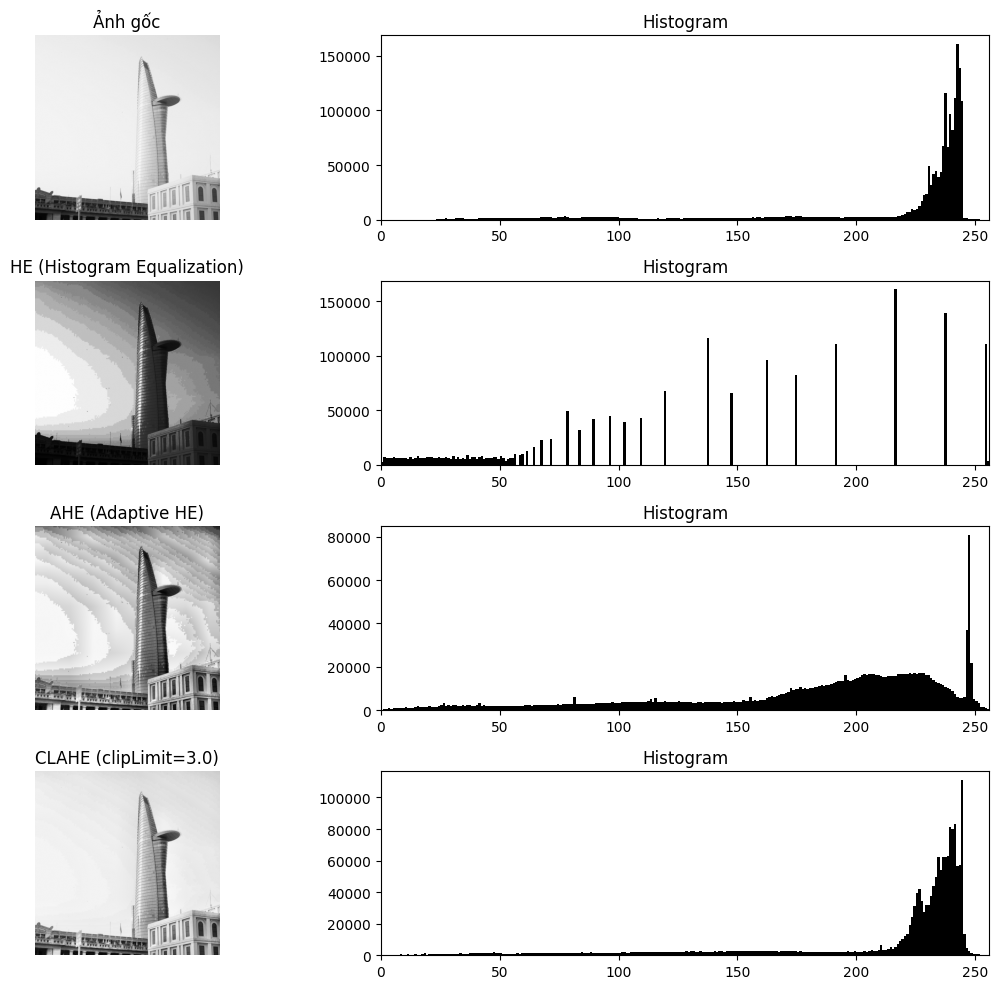

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def SoSanh_Histogram(image_path, clip_limit=3.0, tile_grid_size=(8,8)):
    # 1. Đọc ảnh và chuyển sang grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Không tìm thấy ảnh: {image_path}")
    
    # 2. Histogram Equalization (HE)
    he = cv2.equalizeHist(img)
    
    # 3. Adaptive Histogram Equalization (AHE)
    ahe = cv2.createCLAHE(clipLimit=40.0, tileGridSize=tile_grid_size).apply(img)
    
    # 4. Contrast Limited Adaptive Histogram Equalization (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size).apply(img)
    
    # 5. Hiển thị ảnh và histogram
    imgs = [img, he, ahe, clahe]
    titles = ["Ảnh gốc", "HE (Histogram Equalization)", 
              "AHE (Adaptive HE)", f"CLAHE (clipLimit={clip_limit})"]
    
    plt.figure(figsize=(12,10))
    
    for i in range(4):
        # ảnh
        plt.subplot(4,2,2*i+1)
        plt.imshow(imgs[i], cmap="gray")
        plt.title(titles[i])
        plt.axis("off")
        
        # histogram
        plt.subplot(4,2,2*i+2)
        plt.hist(imgs[i].ravel(), bins=256, range=(0,256), color='black')
        plt.title("Histogram")
        plt.xlim([0,256])
    
    plt.tight_layout()
    plt.show()
    
    return {"goc": img, "he": he, "ahe": ahe, "clahe": clahe}

# Test
results = SoSanh_Histogram("img/bitexco.jpg", clip_limit=3.0, tile_grid_size=(8,8))
